# NLP Workshop : Text Classification

In this workshop we'll learn about a NLP (Natural Language Processing) technique called Text Classification. This means to identify which catagory a piece of text belongs. An example application of this is sentiment analysis, detecting positive or negative texts.

We will use a dataset from crowdflower about hate speech - the use case is detecting offensive language on social media.

*Note: Install the following missing libraries if using the docker image build:*


In [ ]:
!pip install gensim
!pip install imblearn
!pip install lightgbm

Need this to init random seed to fixed value, so we get consistent results..

In [1]:
import numpy as np

np.random.seed(42)

## 1. Loading data

We start by loading the dataset, for this we use [Pandas](https://pandas.pydata.org/)

In [2]:
import pandas as pd

df = pd.read_csv('twitter-hate-speech.csv', index_col=0)

## 2. Quick dataset overview

Now that the data is loaded, we'll have a quick look at what's available: What information do we have?

I'll explain the columns you see in the dataset sample output:

- **count** : Number of human annotations for this sample
- **hate_speech** : Times annotated as containing hate speech
- **offensive_language** : Times annotated as containing offensive language
- **neither** : Times annotated as not containing hatefull of offensive language (normal, respectfull language)
- **class** : Human annotated category, max votes determines category (0=Hate, 1=Offensive, 2=Neither)
- **tweet** : The tweet's text

From these available columns we'll use **class** as the value we try to predict and **tweet** as input to determine the class.

In [3]:
pd.set_option('max_colwidth', 140)

df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash ou...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


Now let's see how much data there is in total?

In [15]:
df.shape

(24783, 6)

### Assignment : Plot the distribution of class in the dataset

An usefull insight can be to have a look at the distriution of categories in the dataset. Plotting can be done using the [Seaborn library](https://seaborn.pydata.org/).

**Your assignment is to plot the distrubution (count) of the categories.**

After plotting you will notice that the categories are not evenly distributed, category one has many more samples than the others. We'll get back to this later!

*Hint: Look at the countplot function in seaborn documentation*

In [4]:
import seaborn as sns

%matplotlib inline

## 3. Text preprocessing

In the data above you can see that the text of the tweets contains lots of slang words, social media specific abbreviations and symbols mixed in. Also there are usernames and hashtags in the text, which we might not want a model to take into consideration for classifying (We'd like the model to learn hatefull/offensive keywords, rather than remember which users use bad language)

For this we'll now look at text preprocessing to clean up the data.

The two libraries we will use here are [sklean](http://scikit-learn.org) and [gensim](https://radimrehurek.com/gensim/).

You can read more here:
- [Gensim text preprocessing](https://radimrehurek.com/gensim/parsing/preprocessing.html)
- [Sklearn text feature extraction](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

First I will show what the default sklearn and gensim preprocessing functions do, then we'll have a deeper look and customize our own preprocessing pipeline.

### Whitespace splitting

First let's see how the output looks when we simply split on whitespace. What you will see is that the tweets are simpy split up into separate words, all noise such as symbols is retained of course.

In [16]:
df['tweet'].head(n=5).apply(lambda x: x.split())

0    [!!!, RT, @mayasolovely:, As, a, woman, you, shouldn't, complain, about, cleaning, up, your, house., &amp;, as, a, man, you, should, alw...
1                                         [!!!!!, RT, @mleew17:, boy, dats, cold...tyga, dwn, bad, for, cuffin, dat, hoe, in, the, 1st, place!!]
2    [!!!!!!!, RT, @UrKindOfBrand, Dawg!!!!, RT, @80sbaby4life:, You, ever, fuck, a, bitch, and, she, start, to, cry?, You, be, confused, as,...
3                                                                       [!!!!!!!!!, RT, @C_G_Anderson:, @viva_based, she, look, like, a, tranny]
4    [!!!!!!!!!!!!!, RT, @ShenikaRoberts:, The, shit, you, hear, about, me, might, be, true, or, it, might, be, faker, than, the, bitch, who,...
Name: tweet, dtype: object

### Sklearn default tokenizer

Next up is the sklean tokenizer. This already does some text cleaning, such as removing symbols and [stopwords](https://en.wikipedia.org/wiki/Stop_words).

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

sklearn_default_preprocessor = CountVectorizer(strip_accents='unicode', stop_words='english').build_analyzer()

df['tweet'].head(n=5).apply(sklearn_default_preprocessor)

0     [rt, mayasolovely, woman, shouldn, complain, cleaning, house, amp, man, trash]
1       [rt, mleew17, boy, dats, cold, tyga, dwn, bad, cuffin, dat, hoe, 1st, place]
2    [rt, urkindofbrand, dawg, rt, 80sbaby4life, fuck, bitch, start, confused, shit]
3                                 [rt, c_g_anderson, viva_based, look, like, tranny]
4              [rt, shenikaroberts, shit, hear, true, faker, bitch, told, ya, 57361]
Name: tweet, dtype: object

### Gensim preprocessor

Finally we will have a look at the gensim preprocessor. This does even more cleaning of the text, for example removing short tokens, numbers and it does [stemming](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).

In [21]:
from gensim.parsing.preprocessing import preprocess_string

df['tweet'].head(n=5).apply(preprocess_string)

0    [mayasolov, woman, shouldn, complain, clean, hous, amp, man, trash]
1       [mleew, boi, dat, cold, tyga, dwn, bad, cuffin, dat, hoe, place]
2      [urkindofbrand, dawg, sbabylif, fuck, bitch, start, confus, shit]
3                             [anderson, viva, base, look, like, tranni]
4                  [shenikarobert, shit, hear, true, faker, bitch, told]
Name: tweet, dtype: object

### Assignment: Customized preprocessor

We have shown a few different approaches for preprocessing text, now we'll create a customized preprocessor that does some extra social media specific data cleaning.

For example:
- Remove usernames
- Remove 'hash' from hashtags
- No stemming

**Take a look at the code below and complete the preprocessing functions**

*Hint: Look at how to lowercase strings and how to use regular expressions in python*

In [ ]:
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, \
    remove_stopwords

def drop_short(tweet):
    # This function is included as an example, it removes short tokens
    return ' '.join(x for x in tweet.split() if len(x) >= 3)

def to_lowercase(tweet):
    return tweet  # TODO Complete this function

def drop_usernames(tweet):
    return tweet  # TODO Complete this function
    
my_filters = [ to_lowercase, drop_usernames, strip_multiple_whitespaces, strip_punctuation, strip_numeric,
               remove_stopwords, drop_short ]

df['tweet'].head(n=5).apply(lambda x: preprocess_string(x, my_filters))

### Bonus assignment: Character NGram preprocessing

In this assignment we'll use a different approach towards preprocessing, based on character ngrams. This means instead of splitting into words, the text is split into groups on N letters.

Using character n-grams instead of words can give you better results, because there is some tolerance for spelling mistakes (if one letter of a word is different, most ngrams will still appear, while the whole word would not match at all). Also symbols such as commas, exclamation marks or even smileys are be taken into account.

**Complete the code below and have a look at the output, experiment with the parameters**

For example trigrams (length three) is often used.

In [ ]:
ngram_preprocessor = CountVectorizer(strip_accents='unicode', analyzer=..., ngram_range=...).build_analyzer()

df['tweet'].head(n=5).apply(...)

## 4. Feature creation

In the above section we have preprocessed the text of the tweets and removed noisy or undesireable words. Also the tweets have been split into separate words, this is called tokenization. With this preparation done, we are now ready to transform the data into a format suitable for a machine learning model.

Machine learning models generally require numerical input, they don't work on text or words directly. Also machine learning models usually require a fixed amount of input columns or features. So in this section we will transform the variable-length tokenized tweets into a fixed set of features.

One method of of transforming variable-length texts to a fixed set of numerical features is using each unique word as a feature, and using the count of that word in the text as the value. This is called bag-of-words, below is an demostrationof this, there are some example sentences and the table shows them transformed into bag-of-words features:

1. I love machine learning
2. I hate learning boring things
3. Machine learning is a passion


| Sentence   | I | Love | Machine | Learning | Hate | Boring | Things | Is | A | Passion |
| ---------- |:-:|:----:|:-------:|:--------:|:----:|:------:|:------:|:--:|:-:|:-------:|
| Sentence 1 | 1 |    1 |       1 |        1 |    0 |      0 |      0 |  0 | 0 |       0 |
| Sentence 2 | 1 |    0 |       1 |        0 |    1 |      1 |      1 |  0 | 0 |       0 |
| Sentence 3 | 0 |    0 |       1 |        1 |    0 |      0 |      0 |  1 | 1 |       1 | 

We are going to do the this now for the tweets using a utility from sklearn, a CountVectorizer.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.parsing.preprocessing import preprocess_string

vectorizer = CountVectorizer(strip_accents='unicode', stop_words='english')

X = vectorizer.fit_transform(df['tweet'].values)
y = df['class'].values

Now let's have a look at what the output is?

In [27]:
X

<24783x35573 sparse matrix of type '<class 'numpy.int64'>'
	with 210603 stored elements in Compressed Sparse Row format>

In [28]:
X.shape

(24783, 35573)

So this transformation has resulted in a matrix of 35573 feature columns, that's probably a few to many. Reason for this is, there is many words appearing once or twice. A machine learning algorithm can't learn much from words that appear so infrequently, or in any case the patterns that it might learn won't apply to many new tweets. So we can safely filter out a lot here. The easiest way is to filter by frequency, we simply drop tokens that appear only in a few examples.

In [29]:
vectorizer = CountVectorizer(min_df=5, strip_accents='unicode', stop_words='english')

X_filtered = vectorizer.fit_transform(df['tweet'].values)

In [30]:
X_filtered.shape

(24783, 4693)

### Assignment: Filtering tokens

In this exercise we will experiment with filtering tokens by frequency to remove low-frequency tokens, since they would likely not be very usefull anyway.

**Experiment with the code below to obtain a feature-matrix of around 500 to 1000 features.**

*Hint: Have a look at the min_df parameter*

In [31]:
vectorizer = CountVectorizer(min_df=..., strip_accents='unicode', stop_words='english')

X_filtered_more = vectorizer.fit_transform(df['tweet'].values)

In [ ]:
X_filtered_more.shape

### Features from preprocessed data

In the examples above we haven't yet used our preprocessing logic, we had just split up words as default. Let's do this now:

In [35]:
vectorizer = CountVectorizer(min_df=10, strip_accents='unicode', analyzer='word',
                             tokenizer=preprocess_string, stop_words='english')

X_preprocessed = vectorizer.fit_transform(df['tweet'].values)

In [36]:
X_preprocessed.shape

(24783, 2164)

### Assignment: Plug in our custom preprocessor

In this exercise you will plug the custom preprocessor we created earlier in to the vectorizer.

**Adjust the code below to use the custom preprocessor logic**

*Hint: Use a lambda function*

In [ ]:
vectorizer = CountVectorizer(min_df=10, strip_accents='unicode', analyzer='word',
                             tokenizer=..., stop_words='english')

X_custom = vectorizer.fit_transform(df['tweet'].values)

### Bonus assignment: Character ngrams as features

In this assignment we'll use a different approach towards features, based on character ngrams. This means instead of splitting into words, the text is split into groups on N letters.

**Make a set of features using character ngrams**

*Hint: Look at CountVectorizer documentation, analyzer='char'*

## 5. Comparing the preprocessing / feature approaches

We have now preprocessed the data and created several variants of features from the data. As a next step we'll apply a basic machine learning model and see which approach of preparing data works best.

We might have some intuitions about what way of preprocessing data might work well for this dataset, but we can't be sure of that untill we calculate the score a model can achieve using those features. For example we might assume that removing stopwords or stemming words will help, but then find out that this actually hurts performance of our model.

We will use a Naive Bayes model. While this is a relatively simple model, it often works well on textual data especially if there is limited training data.

Evalutating each data processing approach is done by cross validation. This means splitting up the data into a training and test set, where the model is trained on the training data and then evaluated on the test data. In this case an improved cross validation approach is used, where the data is shuffled and split up into N different training/test combinations; the score from each of the N combinations contributes to a final average score.

Here is an image to visualize this cross validation:

![Cross Validation](./cross-validation.png "Cross Validation")

In [41]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.naive_bayes import MultinomialNB

cv = ShuffleSplit(n_splits=10, test_size=0.2)

scores = cross_val_score(MultinomialNB(), X, y, cv=cv)
print("Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Score: 0.87 (+/- 0.00)


### Assignment: Comparing features

Above is shown how to compute the score of one approach of preprocessing. Now it's time to compute the scores for the other approaches.

**Compute the scores for the other preprocessing and feature approaches, analoguous to above**

*Hint: Copy and adjust the code above*

## 6. Machine learning models

Above we have compared various preprocessing and feature approaches to see how they do, we used a naive bayes model there. Of course there is many machine learning models that can be used. In this section we'll have a look at a few machine learning models that are popular in the NLP area.

We'll compute scores for various models, all using the filtered dataset.

First is the baseline, naive bayes:

In [68]:
scores = cross_val_score(MultinomialNB(), X, y, cv=cv)
print("Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Score: 0.87 (+/- 0.00)


### Assignment: Compute scores with other models

In this assignment you will compute scores for several other machine learning models.

**Complete the code below and compute scores for all models**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClasifier

models = [
    MultinomialNB(),
    LogisticRegression(),
    LogisticRegression(multi_class='multinomial', solver='newton-cg'),
    DecisionTreeClassifier(min_samples_split=50),
    LinearSVC(),
    LGBMClasifier()
]

## 7. Evaluation metrics & class imbalance

We have now evaluated several approaches of preprocessing, feature creation and different machine learning models. For this evaluation we have used cross validation using a default metric, accuracy.

It's good to keep in mind, such an evaluation metric just one number, that means it is a very simplified view of the world. In many cases it can be good practise to use different evaluation metrics and do more in-depth diagnosis of your machine learning model to determine how well it is really doing.

Let's calculate a few different metrics and see what this tells us.

In [127]:
metrics = [
    'accuracy',
    'f1_micro',
    'f1_macro',
    'f1_weighted'
]

for metric in metrics:
    scores = cross_val_score(MultinomialNB(), X_filtered, y, cv=cv, scoring=metric)
    print("Metric %s score: %0.2f (+/- %0.2f)" % (metric, scores.mean(), scores.std()))

Metric accuracy score: 0.88 (+/- 0.01)
Metric f1_micro score: 0.89 (+/- 0.00)
Metric f1_macro score: 0.69 (+/- 0.01)
Metric f1_weighted score: 0.88 (+/- 0.01)


The metrics used above are accuracy and F1 score, with several variants of the F1 metric. The variants of the F1 metric are weighted differently for multiclass and could tell us if we have similar performance on each class/category. Apparently we do not! 

Let's have a closer look...

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test), target_names=('Hate', 'Offensive', 'Neither')))

             precision    recall  f1-score   support

       Hate       0.48      0.29      0.36       272
  Offensive       0.93      0.95      0.94      3834
    Neither       0.85      0.88      0.87       851

avg / total       0.90      0.90      0.90      4957



The classification report above tells us how well we do for the different classes / categories. In this case it seems we doing great in some and less well in other cases.

One reason for this could be the imbalance in the dataset, the support column above tells you how many data samples there were per category. Remember the distribution plot we made earlier?

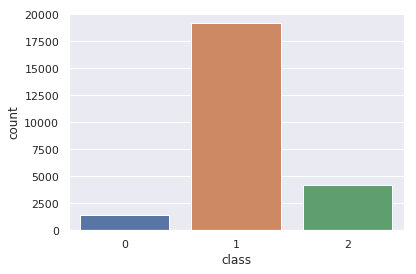

In [73]:
import seaborn as sns

%matplotlib inline

sns.countplot(df['class'])

### Class weighting

The effect this imbalance has, is that because there are many more samples for the 'Offensive' class, those have a larger impact on the training of the model.

One way of dealing with this is weighting errors for each classes differently to compensate.

In [74]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight='balanced')
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test), target_names=('Hate', 'Offensive', 'Neither')))

             precision    recall  f1-score   support

       Hate       0.29      0.56      0.38       272
  Offensive       0.96      0.87      0.91      3834
    Neither       0.81      0.92      0.86       851

avg / total       0.90      0.86      0.88      4957



The above has improved the situation slightly, but the results are still not ideal. We can try out different versions of weighting.

In [75]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight={0: 5.0, 1: 1.0, 2: 5.0})
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test), target_names=('Hate', 'Offensive', 'Neither')))

             precision    recall  f1-score   support

       Hate       0.37      0.49      0.42       272
  Offensive       0.96      0.90      0.93      3834
    Neither       0.80      0.92      0.86       851

avg / total       0.90      0.88      0.89      4957



### Assignemnt: Class weighting

In this assignment we will experiment with class weighting to improve model performance on classes with fewer samples.

**Experiment with class weights and try to find parameters that improve the F1 score for the categories**

### Re-sampling
Re-sampling
Another approach to dealing with class imbalance is re-sampling. One library for this is SMOTE. Let's have a look!

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_sample(X_train, y_train)

In [85]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
model.fit(X_resampled, y_resampled)

print(classification_report(y_test, model.predict(X_test), target_names=('Hate', 'Offensive', 'Neither')))

             precision    recall  f1-score   support

       Hate       0.28      0.54      0.37       272
  Offensive       0.95      0.88      0.91      3834
    Neither       0.83      0.88      0.86       851

avg / total       0.89      0.86      0.87      4957



### Assignment: Re-sampling methods

We showed how to use one particular resampling method, there are many more of course. Here you can experiment with a few.

**Try out a few re-sampling methods and see if they improve the scores.**

*Hint have a look at imbalanced-learn documentation*